In [40]:
import pandas as pd
from gensim.utils import simple_preprocess
from gensim import corpora

df_comments = pd.read_csv("raila_youtube_comments_analysis.csv")

# Step 1: Clean and tokenize comments
df_comments['tokens'] = df_comments['comment'].apply(lambda x: simple_preprocess(str(x)))


In [41]:
# Create dictionary and corpus
dictionary = corpora.Dictionary(df_comments['tokens'])
corpus = [dictionary.doc2bow(text) for text in df_comments['tokens']]


In [42]:
from gensim.models.ldamodel import LdaModel

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=5,
    random_state=42,
    passes=10
)


In [43]:
topic_data = []

for i, row in enumerate(lda_model[corpus]):
    row = sorted(row, key=lambda x: x[1], reverse=True)
    topic_num, prop_topic = row[0]
    topic_data.append((int(topic_num), round(prop_topic, 4)))

# Add results to your dataframe
df_comments['Dominant_Topic'] = [t[0] for t in topic_data]
df_comments['Topic_Confidence'] = [t[1] for t in topic_data]


In [44]:
topic_labels = {
    0: "Peace & Rest",
    1: "Family & Winnie",
    2: "Legacy & Heroism",
    3: "Political Reaction",
    4: "Music & Pop Culture"
}

df_comments['Topic_Label'] = df_comments['Dominant_Topic'].map(topic_labels)


In [45]:
df_comments[['comment', 'Dominant_Topic', 'Topic_Label', 'Topic_Confidence']].head(10)


,comment,Dominant_Topic,Topic_Label,Topic_Confidence
0,This Ai video is a disrespect to raila’s legacy,3,Political Reaction,0.9101
1,I miss raila,2,Legacy & Heroism,0.7275
2,Jumping ya buda imenimaliza.youve made my nigh...,2,Legacy & Heroism,0.9189
3,Walai KENYANS 🇰🇪 this is too much yawa freedom...,2,Legacy & Heroism,0.9377
4,"Cheki baba akiruka,,😂😂😂\nMastyle deadly deadly",1,Family & Winnie,0.8852
5,Nani mwingine aliona hiyo smile kabla ya vita😂😂😂,3,Political Reaction,0.9107
6,So Ruto always starts the fight 😅,0,Peace & Rest,0.8833
7,"Mbona huyu Raila hapigani kuua,ni kama wanache...",3,Political Reaction,0.9193
8,Amazing one Kenyans,2,Legacy & Heroism,0.7992
9,Baba Baba👏👏👏👏 come on baba,2,Legacy & Heroism,0.8642


In [47]:
import re

def assign_topic(comment):
    text = comment.lower()
    if re.search(r'\brip|rest|peace|salama|eternal\b', text):
        return 'Peace & Rest'
    elif re.search(r'\bbaba|winnie|family|daughter\b', text):
        return 'Family & Winnie'
    elif re.search(r'\bkenya|hero|leader|legacy|history|jowi|icon\b', text):
        return 'Legacy & Heroism'
    elif re.search(r'\bpolitics|uhuru|ruto|power|president\b', text):
        return 'Political Reaction'
    elif re.search(r'\bsong|music|dance|video|clip\b', text):
        return 'Pop Culture'
    else:
        return 'Other'

df_comments['Topic_Label'] = df_comments['comment'].apply(assign_topic)


In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Example pipeline
vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1,2))
X = vectorizer.fit_transform(df_comments['comment'])
y = df_comments['Topic_Label']  # your manually defined topics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

print("Accuracy:", model.score(X_test, y_test))


Accuracy: 0.7272727272727273


In [49]:
df_comments['Predicted_Topic'] = model.predict(vectorizer.transform(df_comments['comment']))


In [50]:
# Predict topic for each comment
df_comments["Predicted_Topic"] = model.predict(vectorizer.transform(df_comments["comment"]))


In [51]:
import pandas as pd

topic_summary = (
    df_comments.groupby(["Predicted_Topic", "sentiment"])
    .size()
    .reset_index(name="Count")
)

topic_summary


,Predicted_Topic,sentiment,Count
0,Family & Winnie,Negative,8
1,Family & Winnie,Neutral,19
2,Family & Winnie,Positive,20
3,Legacy & Heroism,Negative,1
4,Legacy & Heroism,Neutral,7
5,Legacy & Heroism,Positive,9
6,Other,Negative,12
7,Other,Neutral,76
8,Other,Positive,37
9,Peace & Rest,Negative,12


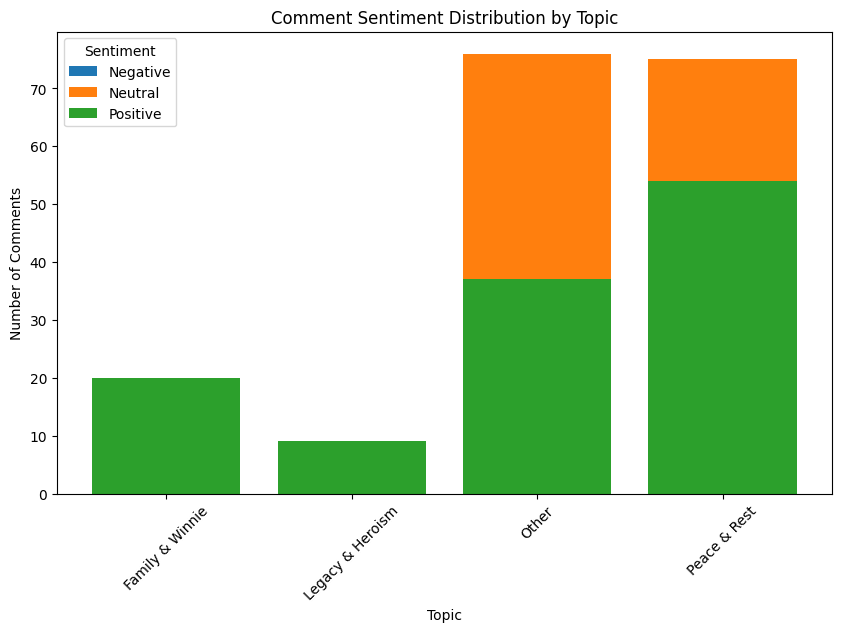

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
for sentiment in topic_summary['sentiment'].unique():
    subset = topic_summary[topic_summary['sentiment'] == sentiment]
    plt.bar(subset['Predicted_Topic'], subset['Count'], label=sentiment)

plt.xlabel("Topic")
plt.ylabel("Number of Comments")
plt.title("Comment Sentiment Distribution by Topic")
plt.legend(title="Sentiment")
plt.xticks(rotation=45)
plt.show()


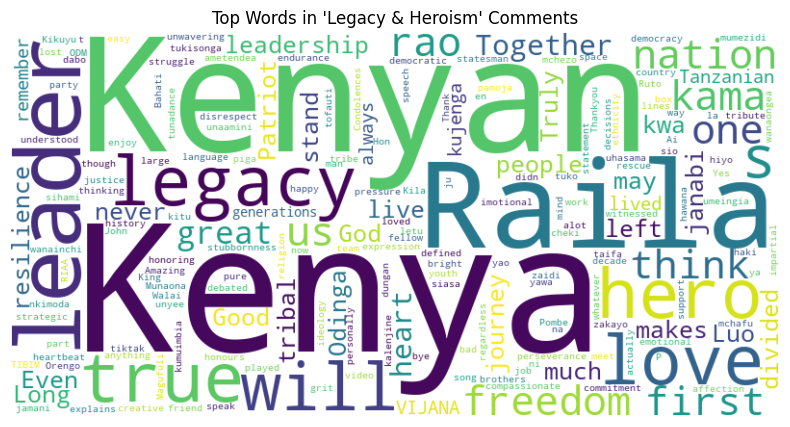

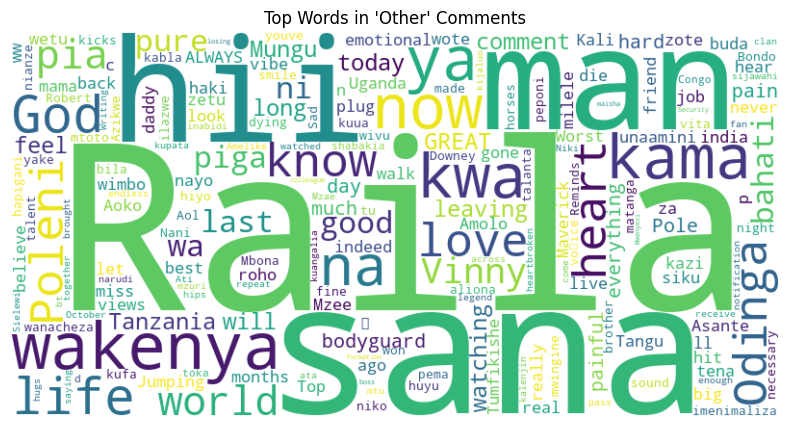

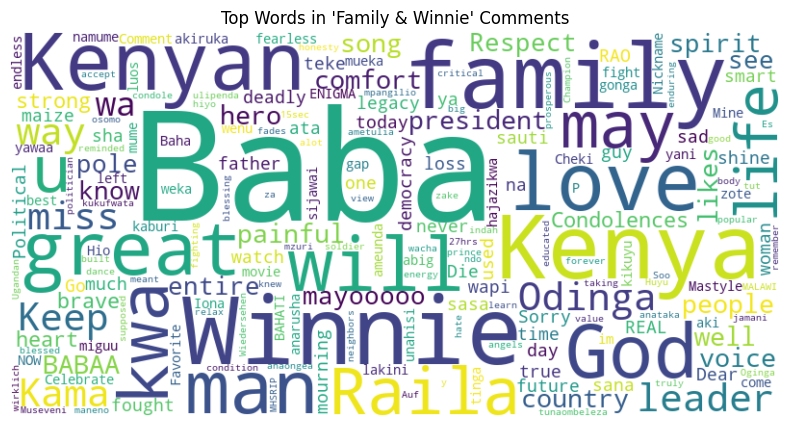

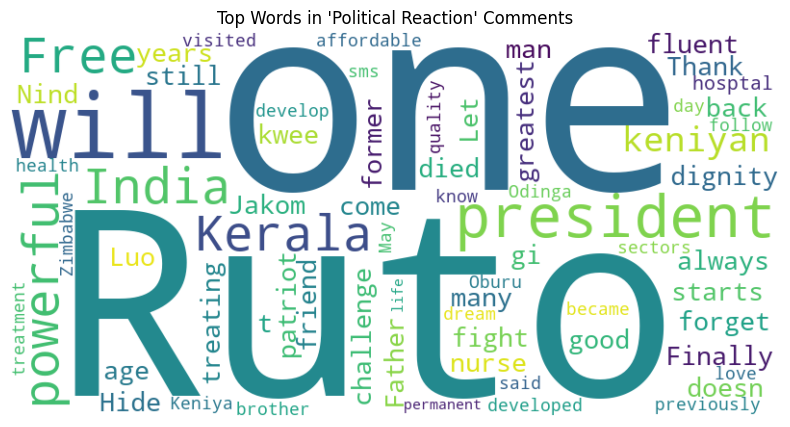

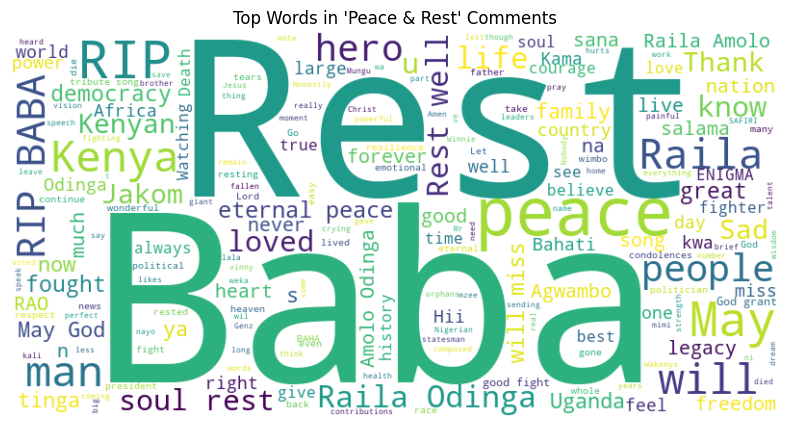

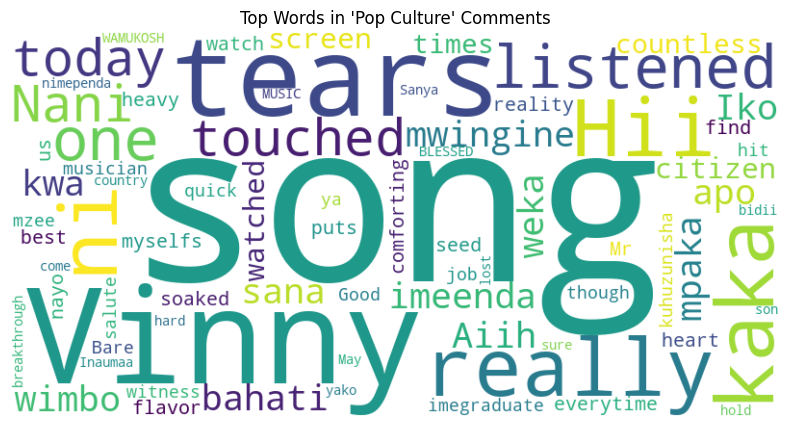

In [58]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

topics = df_comments["Topic_Label"].unique()

for topic in topics:
    text = " ".join(df_comments[df_comments["Topic_Label"] == topic]["comment"])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Top Words in '{topic}' Comments")
    plt.show()


In [59]:
df_comments["Topic_Label"].value_counts()


Topic_Label
Peace & Rest          126
Other                  96
Family & Winnie        58
Legacy & Heroism       33
Pop Culture             9
Political Reaction      8
Name: count, dtype: int64

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Take sample comments per topic to represent their meaning
topic_samples = (
    df_comments.groupby("Topic_Label")["comment"]
    .apply(lambda x: " ".join(x.sample(min(20, len(x)))))  # up to 20 per topic
)

# Convert to TF-IDF embeddings
vectorizer = TfidfVectorizer(stop_words="english")
topic_vectors = vectorizer.fit_transform(topic_samples)

# Compute similarity between topics
sim_matrix = cosine_similarity(topic_vectors)
similarity_df = pd.DataFrame(sim_matrix, index=topic_samples.index, columns=topic_samples.index)

similarity_df


Topic_Label,Family & Winnie,Legacy & Heroism,Other,Peace & Rest,Political Reaction,Pop Culture
Topic_Label,,,,,,
Family & Winnie,1.000000,0.198636,0.072145,0.373884,0.050008,0.041419
Legacy & Heroism,0.198636,1.000000,0.096611,0.089318,0.025829,0.041979
Other,0.072145,0.096611,1.000000,0.047378,0.039785,0.092960
Peace & Rest,0.373884,0.089318,0.047378,1.000000,0.040739,0.025387
Political Reaction,0.050008,0.025829,0.039785,0.040739,1.000000,0.014676
Pop Culture,0.041419,0.041979,0.092960,0.025387,0.014676,1.000000


In [61]:
merged_labels = {}
used = set()
threshold = 0.7  # you can adjust to 0.6 or 0.8 depending on how strict you want merging

for topic_i in similarity_df.index:
    if topic_i in used:
        continue

    # find all topics similar to this one
    close_topics = []
    for topic_j in similarity_df.columns:
        if similarity_df.loc[topic_i, topic_j] > threshold:
            close_topics.append(topic_j)

    # mark all close ones as part of this cluster
    for t in close_topics:
        used.add(t)
        merged_labels[t] = f"Cluster_{topic_i}"


In [62]:
df_comments["Topic_Label"].value_counts()


Topic_Label
Peace & Rest          126
Other                  96
Family & Winnie        58
Legacy & Heroism       33
Pop Culture             9
Political Reaction      8
Name: count, dtype: int64

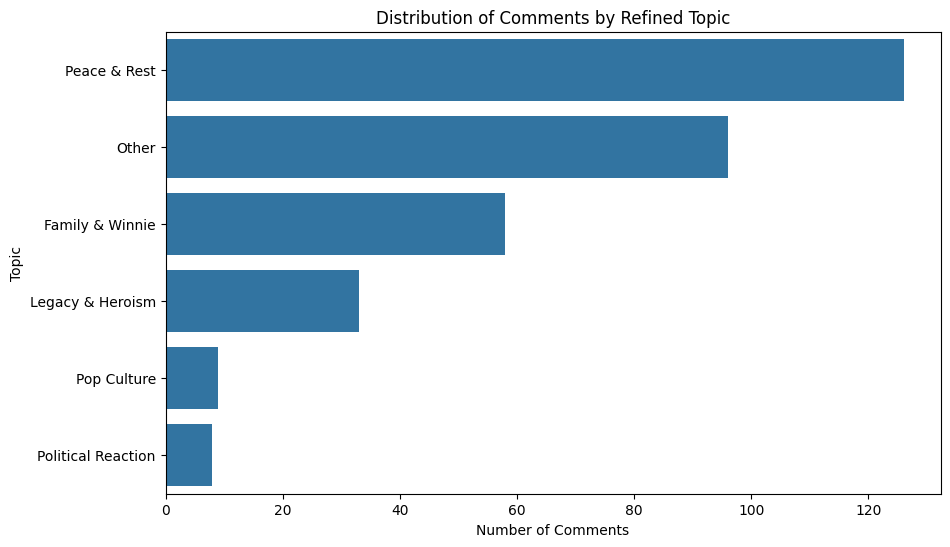

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.countplot(data=df_comments, y="Topic_Label", order=df_comments["Topic_Label"].value_counts().index)
plt.title("Distribution of Comments by Refined Topic")
plt.xlabel("Number of Comments")
plt.ylabel("Topic")
plt.show()


In [64]:
for topic in df_comments["Topic_Label"].unique():
    print(f"\n🧠 Topic {topic}")
    display(df_comments[df_comments["Topic_Label"] == topic]["comment"].head(5))



🧠 Topic Legacy & Heroism


0       This Ai video is a disrespect to raila’s legacy
3     Walai KENYANS 🇰🇪 this is too much yawa freedom...
8                                   Amazing one Kenyans
17    Kenya sihami hiyo tiktak ya rao nkimoda en dun...
19    Kenyans jamani mumezidi....\nIf God had anythi...
Name: comment, dtype: object


🧠 Topic Other


1                                          I miss raila
2     Jumping ya buda imenimaliza.youve made my nigh...
5      Nani mwingine aliona hiyo smile kabla ya vita😂😂😂
7     Mbona huyu Raila hapigani kuua,ni kama wanache...
12                         Robert Downey kufa brother's
Name: comment, dtype: object


🧠 Topic Family & Winnie


4        Cheki baba akiruka,,😂😂😂\nMastyle deadly deadly
9                            Baba Baba👏👏👏👏 come on baba
10                   Baba anarusha teke na miguu zote😂😂
11       Hio Teke ya Baba sijawai Iona ata kwa movie😂😂😂
16    wa kenya we are fearless yani baba hajazikwa l...
Name: comment, dtype: object


🧠 Topic Political Reaction


6                      So Ruto always starts the fight 😅
46     Let the former president come back  again Ruto...
105    😢 Thank you president Ruto for treating one of...
125    Luo are Finally Free...... Where will Ruto Hide ,
129    At his age he still was so powerful and fluent...
Name: comment, dtype: object


🧠 Topic Peace & Rest


20    Baba Raila you have gone so soon. You were our...
27    WE LOVE YOU BABA 💔💔💔💔 REST IN PARADISE! SAFIRI...
30    Hii wimbo nayo imeniguza sana😢😢😢 mnipe ata lik...
34    Bahati wa kwanza uyu Rip Baba hii itakumbukwa ...
36    I am from Eritrea 🇪🇷 when I see this heartbrea...
Name: comment, dtype: object


🧠 Topic Pop Culture


28     Have listened to your songs but this one has t...
29     Aiih bahati wimbo imeenda sana mpaka Iko kwa c...
40     I have watched this countless times, and every...
181    Vinny flavor and Mr seed songs are the best, t...
186    Hii song nayo imegraduate🔥🔥🔥salute to you mzee...
Name: comment, dtype: object

In [65]:
# Find the video ID that contains the target comment
target_comment = "Baba anarusha teke na miguu zote😂😂"

match = df_comments[df_comments["comment"].str.contains(target_comment, case=False, na=False)]

print(match[["video_id", "comment"]])


       video_id                             comment
10  in19F5V7iW4  Baba anarusha teke na miguu zote😂😂


In [67]:
video_to_remove = "in19F5V7iW4"

In [68]:
import pandas as pd
df_videos = pd.read_csv("raila_youtube_data.csv")

In [76]:
df_videos.head()

,title,channel,publishedAt,description,videoId
0,Former president Uhuru Kenyatta visits Raila O...,NTV Kenya,2025-10-20T19:10:52Z,Subscribe to NTV Kenya channel for latest Keny...,ky5fsUOOJeM
1,Raila Odinga accorded a 17-gun salute in recog...,Citizen TV Kenya,2025-10-19T14:08:05Z,CitizenTV #citizendigital.,U4PdNB9-Wx0
2,Kenya’s revered opposition leader Raila Odinga...,Al Jazeera English,2025-10-20T04:45:01Z,Mourners in Kenya have said their final farewe...,I5PEqG5tkRE
3,Winnie Odinga&#39;s last tributes to the late ...,Citizen TV Kenya,2025-10-19T08:22:33Z,CitizenTV #citizendigital.,HaOkxbxdfEA
4,Uhuru Kenyatta visits Raila Odinga&#39;s grave...,KTN News Kenya,2025-10-20T18:17:23Z,ktnnews #KTNNewsDigital #ktnkenya #KTNTV #KTNH...,s7J2x5oBnDA


In [77]:
df_videos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        20 non-null     object
 1   channel      20 non-null     object
 2   publishedAt  20 non-null     object
 3   description  19 non-null     object
 4   videoId      20 non-null     object
dtypes: object(5)
memory usage: 932.0+ bytes
